In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('GangaRiver').master('spark://namenode:7077').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

22/11/19 15:04:14 WARN Utils: Your hostname, nikhil resolves to a loopback address: 127.0.1.1; using 192.168.68.127 instead (on interface usb0)
22/11/19 15:04:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/19 15:04:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv('ganga.csv', header = True, inferSchema = True)

# Print the schema of the dataset
df.printSchema()

root
 |-- DO: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- ORP: double (nullable = true)
 |-- Cond: double (nullable = true)
 |-- Temp: double (nullable = true)
 |-- WQI: double (nullable = true)
 |-- Status: string (nullable = true)



# Data Preprocessing 

In [4]:
# top 20 rows of the dataset
df.show()

# Number of rows in the dataset.
print (f'Number of rows in the dataset: ', df.count())

+-----------+----------+----------+-----------+---------+-----------+---------+
|         DO|        pH|       ORP|       Cond|     Temp|        WQI|   Status|
+-----------+----------+----------+-----------+---------+-----------+---------+
| 8.63052641|  8.879727|0.08482218| 0.04469828|22.650238|20.50452959|     Fair|
|8.644232787|  8.866815|0.08629203|0.044651296|22.567017|20.35919708|     Fair|
|  13.501176| 12.359906|0.14290023|   46.19519|18.400787|42.01432799|Very Poor|
|9.458531041| 12.825684|0.14623594|   52.60968|18.013641|47.74543444|Very Poor|
|  12.409351| 12.998978|0.14672422|  52.399826| 18.18457|46.92559347|Very Poor|
|  13.330035| 13.105331|0.14353323|  41.708813|18.367126|47.72259341|Very Poor|
|  10.858296|13.1836815|0.14233637|   52.92656|18.268341|48.31563432|Very Poor|
|   11.62481| 13.263382|0.14168048|   53.68222|18.302948|48.92207343|Very Poor|
|  13.488875| 13.269672|0.14186788|  53.700462|18.293518|48.97121512|Very Poor|
|   15.40315| 13.209754|0.14616036|  53.

In [5]:
# Count the number of None, null, empty string present in the dataset.
from pyspark.sql.functions import col,isnan,when,count
df2 = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
df2.show()

print ("0 null values present in the dataset")

+---+---+---+----+----+---+------+
| DO| pH|ORP|Cond|Temp|WQI|Status|
+---+---+---+----+----+---+------+
|  0|  0|  0|   0|   0|  0|     0|
+---+---+---+----+----+---+------+

0 null values present in the dataset


In [6]:
# Summary of numeric features

numeric_features = [t[0] for t in df.dtypes if t[1] == 'double']
df.select(numeric_features).describe().toPandas()

,summary,DO,pH,ORP,Cond,Temp,WQI
0,count,46528,46528,46528,46528,46528,46528
1,mean,8.249896476546015,9.872368776500354,0.06982530335490471,316.815828455163,25.7991232931672,29.044676842514022
2,stddev,0.8755463641092607,1.419020860509747,0.11891145124722766,176.4085819915899,2.971161880817394,12.125888570451846
3,min,7.007747,7.646097,-0.82393026,0.044651296,15.909393,4.713774295
4,max,19.918926,13.971594,0.21243644,610.3731,30.691772,63.32105591


In [7]:
# Print all classes for target column
df.select('Status').distinct().show()
classes_count = df.select('Status').distinct().count()
print ("There are ", classes_count, " classes in target column")

+---------+
|   Status|
+---------+
|Excellent|
|     Good|
|     Fair|
|Very Poor|
|     Poor|
+---------+



There are  5  classes in target column


In [8]:
# Counting the classes distribution
df.groupBy('Status').count().show()

+---------+-----+
|   Status|count|
+---------+-----+
|Excellent| 2659|
|     Good| 4632|
|     Fair|16779|
|Very Poor| 6840|
|     Poor|15618|
+---------+-----+



# Feature Extraction

## Correlations between independent variables.

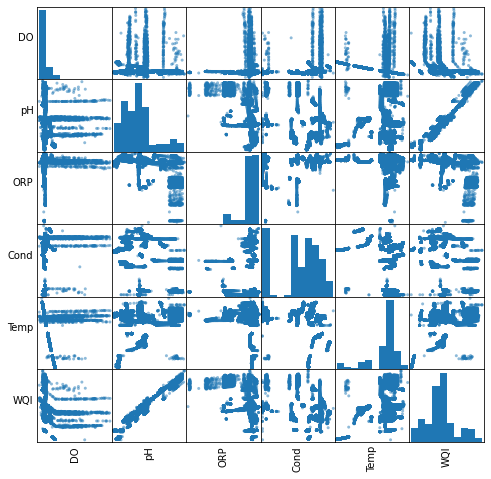

In [9]:
import pandas as pd

numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

From the above correlation matrix it can be seen that the WQI and pH have positive correlation and hence one of these feature can be removed.

## Machine Learning

## Preparing data for machine learning
The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

In [10]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
stages = []

indexer = StringIndexer(inputCol="Status", outputCol="label")
stages += [indexer]

assemblerInputs = numeric_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [11]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [59]:
df.select(['features', 'label'])

DataFrame[features: vector, label: double]

We have now feature columns and label columns.

Now, data is splitted randomly into train and test sets, and set seed for reproducibility

In [60]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32610
Test Dataset Count: 13918


In [72]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, regParam=0.0, elasticNetParam=0.8)
lrModel = lr.fit(train)

In [73]:
predictions = lrModel.transform(test)
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 4956|
|       1.0| 4730|
|       4.0|  822|
|       3.0| 1326|
|       2.0| 2084|
+----------+-----+



In [74]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("label")
evaluator.setPredictionCol ("prediction")
print("Test Area under ROC: ", evaluator.evaluate (predictions))

Test Area under ROC:  0.9919559703761459


In [75]:
from pyspark.mllib.evaluation import MulticlassMetrics
preds_and_labels = predictions.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

/home/nikhil/spark3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [76]:
print(metrics.confusionMatrix())

DenseMatrix([[4.933e+03, 7.500e+01, 0.000e+00, 1.000e+00, 1.000e+00],
             [7.000e+00, 4.647e+03, 4.000e+00, 0.000e+00, 0.000e+00],
             [2.000e+00, 8.000e+00, 2.080e+03, 0.000e+00, 0.000e+00],
             [1.400e+01, 0.000e+00, 0.000e+00, 1.325e+03, 0.000e+00],
             [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.210e+02]])


In [77]:

# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Weighted recall = 0.9919528667912055
Weighted precision = 0.9920241928386934
Weighted F(1) Score = 0.9919559703761459
Weighted F(0.5) Score = 0.991989120439517
Weighted false positive rate = 0.003992130065752851
